# Trench normal analysis
J.C. Graciosa, M. Zuhair

- run this file in python version above 3.0 (base in this system) because some line of codes for normal-trench profiles are compatible with version above above 3.0

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib as mpl

# for beachball - there are some error with using obspy
from pyrocko.plot import beachball
from pyrocko import moment_tensor as mtm

from obspy.core import UTCDateTime

import cartopy 
import cartopy.mpl.geoaxes
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
from pathlib import Path

import seaborn as sns
sns.set()
sns.set_style(style='white') 
sns.set_style("ticks", {"xtick.major.size": 0.5, "ytick.major.size": 0.5})

%matplotlib inline

In [2]:
root_dir = Path(os.getcwd())
root_dir

PosixPath('/Users/mohd0001/PhD_Monash/Paper2/trench-normal-seismicity/ntbk')

In [3]:
# root_dir = Path(os.getcwd())
fname = root_dir/'data/eq_data/SUeq_data.csv'     # filename 'sum_merged_collated_nets.csv' containing moment tensor - this is from before so this is not updated
slab_fname = root_dir/'data/slab_data/sum_slab2_dep_no_nan.csv'  # slab data without any nan values - just for mapping 
depth_fname = root_dir/'data/slab_data/dep_at_prof_end_50.csv'   # csv containing the sampled slab depth along trench
thk_fname = root_dir/'data/slab_data/thk_at_prof_end_50.csv'     # csv containing the sampled slab thickness along trench 
trench_xy_plt = root_dir/'data/trench_data/sum_full.txt'         # trench in Southeast Asia -just for mapping

# fname = '/Users/mohd0001/trench-normal-seismicity/data/eq_data/sum_merged_collated_nets.csv'

step_debug=500 ##added this line for 500 km step

trench_plt = pd.read_csv(trench_xy_plt, sep=',', header = None)
trench_plt.columns = ['LON', 'LAT']

depth_df = pd.read_csv(depth_fname)
thk_df = pd.read_csv(thk_fname)

depth_df = depth_df.sort_values('ALONG')
depth_df['LENGTH'] = np.abs(depth_df['LENGTH'])

depth_df['AREA'] = depth_df['LENGTH']*thk_df['LENGTH']

eq_df = pd.read_csv(fname, header = 'infer')
slab_df = pd.read_csv(slab_fname, header = 'infer')
slab_df = slab_df.sample(frac=0.3, replace=False, random_state=1)

# drop duplicates soon
eq_df = eq_df.drop_duplicates(subset='EVENT_ID', keep = 'last') # keep last (probably updates)
eq_df["ALONG"] = (eq_df["ALONG"]//step_debug)*step_debug ### added this line for step 500 km

max_pos = eq_df['ALONG'].max()


## Assign earthquake type using methodology from Frohlich and Apperson 1992

In [4]:
# try to be strict first with the classification - follow Frohlich 1992
sin_thrust = (np.sin(eq_df['T_PL']*np.pi/180))**2
sin_ss = (np.sin(eq_df['N_PL']*np.pi/180))**2
sin_norm = (np.sin(eq_df['P_PL']*np.pi/180))**2

classif = []

for thrust, ss, norm in zip(sin_thrust, sin_ss, sin_norm):
    if thrust > 0.59:
    #if max(thrust, ss, norm) == thrust:
        classif.append('THRUST')
    elif norm > 0.75:
    #elif max(thrust, ss, norm) == norm:
        classif.append('NORM')
    elif ss > 0.75:
    #elif max(thrust, ss, norm) == ss:
        classif.append('SS')
    else:
        if thrust > norm and ss > norm:
            classif.append('O_THRUST')
        elif norm > thrust and ss > thrust:
            classif.append('O_NORM')
        else:
            classif.append('ODD')

eq_df['SINSQ_T'] = sin_thrust
eq_df['SINSQ_SS'] = sin_ss
eq_df['SINSQ_N'] = sin_norm
eq_df['TYPE'] = classif

### I. Threshold sea-ward direction

# Plot the T, N, P axes in map view to see how they vary

In [5]:
df_to_use = eq_df.reset_index() # resetting of index is important

In [6]:
# df_to_use = df_to_use[(df_to_use['MW'] >= 5.1)]

df_to_use.sort_values(by = 'MW', ascending = False, inplace = True)

df_to_use['DATE'] = pd.to_datetime(df_to_use['DATE']) # change dtype to datetime format
df_to_use['DATE'] = df_to_use['DATE'].dt.strftime('%Y-%m-%d') # change dtype to object

# df_to_use['DATE'] and df_to_use['TIME'] should be object (str) to perform + operator

df_to_use_dummy = np.array(df_to_use['DATE'] + ' ' + df_to_use['TIME'])

df_to_use_ev_time = []

for val in df_to_use_dummy:
    df_to_use_ev_time.append(UTCDateTime(val))

    
ref_date = df_to_use_ev_time[0]

df_to_use_ev_time = np.array(df_to_use_ev_time)

date = []

for val in df_to_use_ev_time:
    date.append(val - ref_date)
    
date = np.array(date) # this is in seconds

df_to_use['YEARS'] = date/31536000

df_to_use = df_to_use.sort_values(by ='YEARS', ascending=True) # this is an important step

In [7]:
df_to_use = df_to_use[(df_to_use['YEARS'] >= 0) &
                      (df_to_use['CLASS'] == 'UPPER') &
                     (df_to_use['DEPTH'] > 0)]

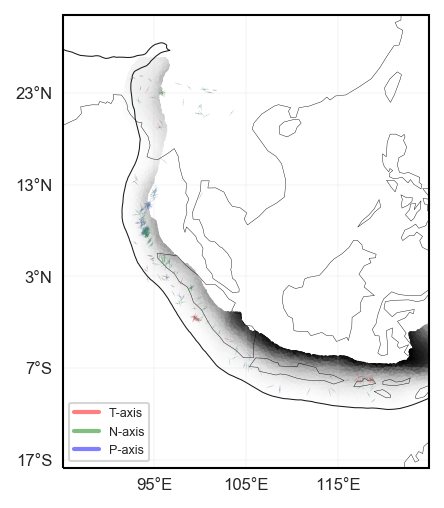

In [8]:
fig, ax = plt.subplots(dpi = 150)
m = plt.axes(projection = cartopy.crs.PlateCarree())

m.set_extent([85, 125, -17, 30])
m.add_feature(cartopy.feature.COASTLINE, linewidth = 0.2)
gl = m.gridlines(linewidth = 0.1, draw_labels = True)
gl.xlocator = mticker.FixedLocator(np.arange(85-10, 125+20, 10))
gl.ylocator = mticker.FixedLocator(np.arange(-17-10, 30+20, 10))
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.ylabel_style = {'size': 8}
gl.xlabel_style = {'size': 8}

m.scatter(slab_df['LON'],slab_df['LAT'], s = 0.5, c = slab_df['DEPTH'], transform=cartopy.crs.PlateCarree(), cmap = plt.cm.gray) #plt.cm.coolwarm
#plot events
#m.scatter(df_to_use['LON'], df_to_use['LAT'], s = 4, c = 'g', edgecolor = 'none', transform=cartopy.crs.PlateCarree(), label = 'Downgoing plate')
m.plot(trench_plt['LON'], trench_plt['LAT'], '-', c = 'k', linewidth = 0.5, transform=cartopy.crs.PlateCarree())

# add the T, N, P visualizations
# sine ang dx
t_dx = 0.4*(np.sin(df_to_use['T_PL']*np.pi/180)**2)*np.sin(df_to_use['T_AZM']*np.pi/180)
t_dy = 0.4*(np.sin(df_to_use['T_PL']*np.pi/180)**2)*np.cos(df_to_use['T_AZM']*np.pi/180)

n_dx = 0.4*(np.sin(df_to_use['N_PL']*np.pi/180)**2)*np.sin(df_to_use['N_AZM']*np.pi/180)
n_dy = 0.4*(np.sin(df_to_use['N_PL']*np.pi/180)**2)*np.cos(df_to_use['N_AZM']*np.pi/180)

p_dx = 0.4*(np.sin(df_to_use['P_PL']*np.pi/180)**2)*np.sin(df_to_use['P_AZM']*np.pi/180)
p_dy = 0.4*(np.sin(df_to_use['P_PL']*np.pi/180)**2)*np.cos(df_to_use['P_AZM']*np.pi/180)

for idx, row in df_to_use.iterrows():
    # plot T
    plt.plot([row['LON'] + t_dx[idx], row['LON'] - t_dx[idx]], [row['LAT'] + t_dy[idx], row['LAT'] - t_dy[idx]], '-', linewidth = 0.3, c = 'r', transform=cartopy.crs.PlateCarree(), alpha = 0.3)
    plt.plot([row['LON'] + n_dx[idx], row['LON'] - n_dx[idx]], [row['LAT'] + n_dy[idx], row['LAT'] - n_dy[idx]], '-', linewidth = 0.3, c = 'g', transform=cartopy.crs.PlateCarree(), alpha = 0.3)
    plt.plot([row['LON'] + p_dx[idx], row['LON'] - p_dx[idx]], [row['LAT'] + p_dy[idx], row['LAT'] - p_dy[idx]], '-', linewidth = 0.3, c = 'b', transform=cartopy.crs.PlateCarree(), alpha = 0.3)

 # manual legend
colors = ['red', 'green', 'blue']
lines = [Line2D([0], [0], color=c, linewidth=2, linestyle='-', alpha = 0.5) for c in colors]
labels = ['T-axis', 'N-axis', 'P-axis']
m.legend(lines, labels, loc = 'lower left', fontsize = 6)


## Plot trench perpendicular profiles 
using df_to_use

In [9]:
# generate a plot of each profile - useful for analysis and visualization

label = 'rDowngoing ($\leq$ 150 km)'
df_to_use = df_to_use.sort_values(by = 'ALONG')

along_val = df_to_use['ALONG'].unique()
max_along = along_val.max()

# change settings accordingly
# fix if changing classification
depth_thresh = 600 # max depth to include in plot - should be positive
thresh_seaward = -400 # original is 100 - plotting limit in the direction of the downgoing plate 
step = 500 # step in trench in km - this depends on the dep_profiles you have
prefix = 'pr_-L0-'
prof_dir = root_dir/'data/profiles/dep_profiles/500_step' # directory containing depth profiles - 100 or 500 km step
thk_dir = root_dir/'data/profiles/thk_profiles/500_step' # directory containing thickness profiles - 100 or 500 km step
out_dir = root_dir/'out/tr_norm_analysis' # output directory

for al in along_val:
    
    num = int(al/step)
    if num < 10:
        fname = prefix + '0' + str(num) + '.txt'
    else:
        fname = prefix + str(num) + '.txt'
        
    prof_fname = prof_dir/fname
    thk_fname = thk_dir/fname
    
    prof_df = pd.read_csv(prof_fname, sep = '\t', header = None)
    thk_df = pd.read_csv(thk_fname, sep = '\t', header = None)
    prof_df.columns = ['LON', 'LAT', 'PROF_DIST', 'X1', 'DEPTH']
    thk_df.columns = ['LON', 'LAT', 'PROF_DIST', 'X1', 'THK']
    
    # get next profile just for better visualization of the area
    if al < max_along:
        num += 1
        if num < 10:
            fname = prefix + '0' + str(num) + '.txt'
        else:
            fname = prefix + str(num) + '.txt'

        prof_fname2 = prof_dir/fname
        prof_df2 = pd.read_csv(prof_fname2, sep = '\t', header = 'infer')
        prof_df2.columns = ['LON', 'LAT', 'PROF_DIST', 'X1', 'DEPTH']
         
    # read the earthquake data subset
    subset = df_to_use[df_to_use['ALONG'] == al].sort_values(by = 'MW', ascending = False)
    
    # plot
    #fig, ax = plt.subplots(dpi = 300)
    fig = plt.figure(constrained_layout = False, figsize= (10, 5), dpi = 300) #w x h

    spec = fig.add_gridspec(ncols = 10, nrows = 5, hspace = 0, wspace = 3)

    ax_l = fig.add_subplot(spec[:, 0:4], projection = cartopy.crs.PlateCarree())
    ax_r = fig.add_subplot(spec[:, 4:10])

    
    # the directions of each profile go from right to left so we need to add a negative
    # this happens since our zero is at Andaman - there is something with how GMT works with curved features
    # GMT start from bottom to top and left to right
    thk_df  = thk_df[prof_df['DEPTH'] >= -(depth_thresh + 20)] # this is correct - limit basis is profile
    prof_df = prof_df[prof_df['DEPTH'] >= -(depth_thresh + 20)]
    ax_r.plot(-prof_df['PROF_DIST'],-prof_df['DEPTH'],'-', color = 'C1', linewidth =1)
    ax_r.plot(-thk_df['PROF_DIST'],-prof_df['DEPTH'] + 0.5*thk_df['THK'], '--', linewidth =0.5, color = 'k')
    
    # events-
    out = ax_r.scatter(subset[subset['TYPE'] == 'THRUST']['P(km)'],subset[subset['TYPE'] == 'THRUST']['DEPTH'], c = 'r', s = 5, alpha = 0.3, edgecolors = 'none')
    out = ax_r.scatter(subset[subset['TYPE'] == 'O_THRUST']['P(km)'],subset[subset['TYPE'] == 'O_THRUST']['DEPTH'], c = 'magenta', s = 5, alpha = 0.3, edgecolors = 'none')
    out = ax_r.scatter(subset[subset['TYPE'] == 'NORM']['P(km)'],subset[subset['TYPE'] == 'NORM']['DEPTH'], c = 'b', s = 5, alpha = 0.3, edgecolors = 'none')
    out = ax_r.scatter(subset[subset['TYPE'] == 'O_NORM']['P(km)'],subset[subset['TYPE'] == 'O_NORM']['DEPTH'], c = 'cyan', s = 5, alpha = 0.3, edgecolors = 'none')
    out = ax_r.scatter(subset[subset['TYPE'] == 'ODD']['P(km)'],subset[subset['TYPE'] == 'ODD']['DEPTH'], c = 'k', s = 5, alpha = 0.3, edgecolors = 'none')
    #cbar = plt.colorbar(out)
    #cbar.mappable.set_clim(0,0.5)
    
    # add the T, N, P visualizations
    # sine ang dx
    # s - trench perpendicular; d - depth
    t_amp = 20#20*(np.sin(subset['T_PL']*np.pi/180)**2)
    n_amp = 20#20*(np.sin(subset['N_PL']*np.pi/180)**2)
    p_amp = 20#20*(np.sin(subset['P_PL']*np.pi/180)**2)
    
    t_dd = t_amp*np.sin(subset['T_PL']*np.pi/180)
    t_ds = t_amp*np.cos(subset['T_PL']*np.pi/180)

    n_dd = n_amp*np.sin(subset['N_PL']*np.pi/180)
    n_ds = n_amp*np.cos(subset['N_PL']*np.pi/180)

    p_dd = p_amp*np.sin(subset['P_PL']*np.pi/180)
    p_ds = p_amp*np.cos(subset['P_PL']*np.pi/180)
    
    # add dip
    dip_dd = 20*np.sin(subset['SLAB_DIP']*np.pi/180)
    dip_ds = 20*np.cos(subset['SLAB_DIP']*np.pi/180)

    for idx, row in subset.iterrows():
        # plot T
        #if row['MW'] < 6:
        #    continue
        if 180 < row['T_AZM'] and row['T_AZM'] < 270: # Q2 and Q3
            ds = -t_ds[idx]
        else:
            ds = t_ds[idx]
        
        ax_r.plot([row['P(km)'] + ds, row['P(km)'] - ds], [row['DEPTH'] + t_dd[idx], row['DEPTH'] - t_dd[idx]], '-', linewidth = 1, c = 'r', alpha = 1)
        
#         # #plot N
        if 180 < row['N_AZM'] and row['N_AZM'] < 270: # Q2 and Q3
            ds = -n_ds[idx]
        else:
            ds = n_ds[idx]
        
        ax_r.plot([row['P(km)'] + ds, row['P(km)'] - ds], [row['DEPTH'] + n_dd[idx], row['DEPTH'] - n_dd[idx]], '-', linewidth = 1, c = 'g', alpha = 1)
        
        # plot P
        if 180 < row['P_AZM'] and row['P_AZM'] < 270: # Q2 and Q3
            ds = -p_ds[idx]
        else:
            ds = p_ds[idx]
        
        ax_r.plot([row['P(km)'] + ds, row['P(km)'] - ds], [row['DEPTH'] + p_dd[idx], row['DEPTH'] - p_dd[idx]], '-', linewidth = 1, c = 'b', alpha = 1)
        
        # plot of the dip
        ax_r.plot([row['P(km)'] + dip_ds[idx], row['P(km)'] - dip_ds[idx]], [row['DEPTH'] + dip_dd[idx], row['DEPTH'] - dip_dd[idx]], '--', linewidth = 0.5, c = 'k', alpha = 0.7)
    
    # manual legend
    colors = ['red', 'blue'] #colors = ['red', 'green', 'blue']
    lines = [Line2D([0], [0], color=c, linewidth=2, linestyle='-', alpha = 1) for c in colors]
    labels = ['T-axis', 'P-axis'] #labels = ['T-axis', 'N-axis', 'P-axis']
    ax_r.legend(lines, labels, fontsize = 8, loc = 'upper right')


    # limit min of x to thresh_seaward
    y_bot, y_top = ax_r.get_ylim()  # return the current ylim
    ax_r.set_ylim([y_bot, y_top])
    x_min, x_max = ax_r.get_xlim()
    ax_r.set_xlim([thresh_seaward, x_max])
    
    # inset of slab depth
    # width and height are width and height of the bbox in the parent axis corner
    bbox_ll_x = 0.00
    bbox_ll_y = 0.07
    bbox_w = 0.5
    bbox_h = 0.23
      
    depth_ax = inset_axes(ax_r, width="100%", height="100%", loc="lower left", 
                        bbox_to_anchor=(bbox_ll_x,bbox_ll_y,bbox_w-bbox_ll_x,bbox_h), 
                          bbox_transform=ax_r.transAxes)
    
    depth_ax.plot(depth_df.ALONG, depth_df.AREA, '-', linewidth = 0.5)
    depth_ax.vlines(al, depth_df.AREA.min(), depth_df.AREA.max(), linestyles = '-', linewidth =0.5, color = 'C1')

    
    if al < max_along:
        depth_ax.vlines(al+step, depth_df.AREA.min(), depth_df.AREA.max(), linestyles = '-', linewidth =0.5, color = 'C1')
    depth_ax.set_yticklabels([])
    depth_ax.set_xlabel('Distance along trench [km]', fontsize = 6)
    depth_ax.tick_params(axis='both', which='major', labelsize=6)
    
    # map 
    axins = inset_axes(ax_r, width="20%", height="40%", loc="center left", 
                       axes_class=cartopy.mpl.geoaxes.GeoAxes, 
                       axes_kwargs=dict(map_projection=cartopy.crs.PlateCarree()))
    axins.set_extent([85, 125, -17, 30])
    axins.add_feature(cartopy.feature.COASTLINE, linewidth = 0.2)
    gl = axins.gridlines(linewidth = 0.1, draw_labels = True)
    gl.xlocator = mticker.FixedLocator(np.arange(85-10, 125+20, 10))
    gl.ylocator = mticker.FixedLocator(np.arange(-17-10, 30+20, 10))
    gl.xlabels_top = False
    gl.ylabels_left = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.ylabel_style = {'size': 5}
    gl.xlabel_style = {'size': 5}

    axins.scatter(slab_df['LON'],slab_df['LAT'], s = 0.5, c = slab_df['DEPTH'], transform=cartopy.crs.PlateCarree(), cmap = plt.cm.gray) #yc, xc -- lists or numpy arrays

    #plot events in the map
    #axins.scatter(subset['LON'], subset['LAT'], s = 0.3, c = 'k', edgecolor = 'none', transform=cartopy.crs.PlateCarree())
    axins.plot(prof_df['LON'], prof_df['LAT'], linewidth = 0.7, color = 'C1', linestyle = '-', transform=cartopy.crs.PlateCarree())
    
    if al < max_along:
        axins.plot(prof_df2['LON'], prof_df2['LAT'], linewidth = 0.7, color = 'C1', linestyle = '-', transform=cartopy.crs.PlateCarree())
    
    axins.plot(trench_plt['LON'], trench_plt['LAT'], '--', c = 'k', linewidth = 0.4, transform=cartopy.crs.PlateCarree())
    
    # map
    along_true = al
    print('Along trench: ', along_true)
     
    ax_r.invert_yaxis()
    ax_r.set_xlabel('Trench-perpendicular distance [km]')
    ax_r.set_ylabel('Depth [km]')
    ax_r.set_title('Along trench: ' + str(along_true) + 'km')
    
    #############
    # map showing the focal mechanism
    #m = plt.axes(projection = cartopy.crs.PlateCarree())
    
    min_lon = subset['LON'].min() - 5
    max_lon = subset['LON'].max() + 5
    min_lat = subset['LAT'].min() - 5
    max_lat = subset['LAT'].max() + 5
    
    ax_l.set_extent([min_lon, max_lon, min_lat, max_lat])
    ax_l.add_feature(cartopy.feature.COASTLINE, linewidth = 0.2)
    gl = ax_l.gridlines(linewidth = 0.1, draw_labels = True)
    gl.xlocator = mticker.FixedLocator(np.arange(85-10, 125+20, 10))
    gl.ylocator = mticker.FixedLocator(np.arange(-17-10, 30+20, 10))
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.ylabel_style = {'size': 8}
    gl.xlabel_style = {'size': 8}

    ax_l.scatter(slab_df['LON'],slab_df['LAT'], s = 0.5, c = slab_df['DEPTH'], transform=cartopy.crs.PlateCarree(), cmap = plt.cm.gray) #plt.cm.coolwarm
    #plot events
    #m.scatter(df_to_use['LON'], df_to_use['LAT'], s = 4, c = 'g', edgecolor = 'none', transform=cartopy.crs.PlateCarree(), label = 'Downgoing plate')
    ax_l.plot(trench_plt['LON'], trench_plt['LAT'], '-', c = 'k', linewidth = 0.5, transform=cartopy.crs.PlateCarree())
    ax_l.set_title('Focal mechanism in area')
    
    idx_val = np.array(subset.index)
    min_zorder = idx_val.min()
            
    for idx, row in subset.iterrows():
        if row['TYPE'] == 'THRUST': 
            color = 'red'
        elif row['TYPE'] == 'NORM': 
            color = 'blue'
        elif row['TYPE'] == 'SS': 
            color = 'green'
        elif row['TYPE'] == 'O_THRUST':
            color = 'magenta'
        elif row['TYPE'] == 'O_NORM':
            color = 'cyan'
        else:
            color = 'k'
        
        #print(row)
        #b = beach(np.array(row[['MRR', 'MTT', 'MPP', 'MRT', 'MPR', 'MTP']]), xy = np.array(row[['LON', 'LAT']]),width = 0.3, linewidth = 0.1, facecolor = color)
        #ax_l.add_collection(b)
        
        row_eq = mtm.MomentTensor(mdd = row['MRR'], mnn = row['MTT'], mee = row['MPP'], mnd = row['MRT'], med = -row['MPR'], mne = -row['MTP'])
        #'MRR', 'MTT', 'MPP', 'MRT', -'MPR', -'MTP' 
        beachball.plot_beachball_mpl(row_eq, ax_l, beachball_type='deviatoric', position=(row['LON'], row['LAT']), size=5, linewidth=0.2, zorder = idx - min_zorder+1, color_t = color)
  
    colors = ['red', 'blue', 'green', 'magenta', 'cyan', 'k']
    lines = [Line2D([0], [0], color=c, linewidth=2, linestyle='-') for c in colors]
    labels = ['Thrust', 'Normal', 'S.S.', 'Obl. thr.', 'Obl. norm.', 'Odd']
    ax_l.legend(lines, labels, fontsize = 7, loc = 'lower left')
    
    out_fname = 'prof_' + str(along_true) + '_km.png'
    out_fname = out_dir/out_fname
    fig.savefig(out_fname, dpi = 300)
    plt.close()


Along trench:  0
Along trench:  500
Along trench:  1000
Along trench:  1500
Along trench:  2000
Along trench:  2500
Along trench:  3000
Along trench:  3500
Along trench:  4000
Along trench:  4500
Along trench:  5000
Along trench:  5500
Along trench:  6000
